# SVM On Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. TFIDF with RBF kernel<br>
11. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For a given Amazon review, classify it as "Possitive"(Rating of 4 or 5) or "Negative"(Rating of 1 or 2).<br>
<br>
Here I'm using Support Vector Machine(SVM) algorithm to classify reviews as 'positive' or 'negative'. To convert a review text to numerical features I'm using bag of words, TF-IDF, avg Word2Vec, TF-IDF weighted Word2Vec. 

In [2]:
# loading required libraries 
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import scipy 
import nltk
import time
import seaborn as sns 
from scipy import stats
from matplotlib import pyplot as plt 

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prf1

from sklearn.model_selection import KFold
from sklearn import cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

import warnings 
warnings.filterwarnings('ignore')

In [3]:
# data standardizer 
from sklearn.preprocessing import StandardScaler

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

## 3. Loading the data

In [4]:
#Loading the data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

Loading the pre-processed data using sqlite. This dataset has no entry with score 3 which is previously removed. And the scores which are greater than 3 are denoted as 'positive' and which are less than 3 are denoted as 'negative' scores.

In [5]:
print(data.shape)
data.head()

(364171, 12)


index      Id   ProductId          UserId                  ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
3  138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
4  138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  positive   939340800   
1                     1                       1  positive  1194739200   
2                     1                       1  positive  1191456000   
3                     1                       1  positive  1076025600   
4                     3                       4  positive  1018396800   

                                      Summary  \
0                   EVERY book is educational   
1  Love the book, miss the hard cover version   
2               chicken soup with rice months   
3      a good swingy rhythm for reading aloud   
4             A great way to learn the months   

                                                Text  \
0  this witty little book makes my son laugh at l...   
1  I grew up reading these Sendak books, and watc...   
2  This is a fun way for children to learn their ...   
3  This is a great little book to read aloud- it ...   
4  This is a book of poetry about the months of t...   

                                         CleanedText  
0  b'witti littl book make son laugh loud recit c...  
1  b'grew read sendak book watch realli rosi movi...  
2  b'fun way children learn month year learn poem...  
3  b'great littl book read nice rhythm well good ...  
4  b'book poetri month year goe month cute littl ...

## 4. Data Preprocessing

In [6]:
data.Score.value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [7]:
# sorting the data according to the time-stamp
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.head()

index      Id   ProductId          UserId               ProfileName  \
0    138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
30   138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
424  417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
330  346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
423  417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

     HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
0                       0                       0  positive  939340800   
30                      2                       2  positive  940809600   
424                     0                       0  positive  944092800   
330                     1                       2  positive  944438400   
423                     0                       0  positive  946857600   

                                               Summary  \
0                            EVERY book is educational   
30   This whole series is great way to spend time w...   
424                               Entertainingl Funny!   
330                            A modern day fairy tale   
423                                         FANTASTIC!   

                                                  Text  \
0    this witty little book makes my son laugh at l...   
30   I can remember seeing the show when it aired o...   
424  Beetlejuice is a well written movie ..... ever...   
330  A twist of rumplestiskin captured on film, sta...   
423  Beetlejuice is an excellent and funny movie. K...   

                                           CleanedText  
0    b'witti littl book make son laugh loud recit c...  
30   b'rememb see show air televis year ago child s...  
424  b'beetlejuic well written movi everyth excel a...  
330  b'twist rumplestiskin captur film star michael...  
423  b'beetlejuic excel funni movi keaton hilari wa...

In [8]:
def partition(x):
    if x == 'positive':
        return 1
    return 0

#Preparing the filtered data
actualScore = sorted_data['Score']
positiveNegative = actualScore.map(partition) 
sorted_data['Score'] = positiveNegative

In [9]:
sorted_data.head()

index      Id   ProductId          UserId               ProfileName  \
0    138706  150524  0006641040   ACITT7DI6IDDL           shari zychinski   
30   138683  150501  0006641040   AJ46FKXOVC7NR        Nicholas A Mesiano   
424  417839  451856  B00004CXX9   AIUWLEQ1ADEG5          Elizabeth Medina   
330  346055  374359  B00004CI84  A344SMIA5JECGM           Vincent P. Ross   
423  417838  451855  B00004CXX9   AJH6LUC1UT1ON  The Phantom of the Opera   

     HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
0                       0                       0      1  939340800   
30                      2                       2      1  940809600   
424                     0                       0      1  944092800   
330                     1                       2      1  944438400   
423                     0                       0      1  946857600   

                                               Summary  \
0                            EVERY book is educational   
30   This whole series is great way to spend time w...   
424                               Entertainingl Funny!   
330                            A modern day fairy tale   
423                                         FANTASTIC!   

                                                  Text  \
0    this witty little book makes my son laugh at l...   
30   I can remember seeing the show when it aired o...   
424  Beetlejuice is a well written movie ..... ever...   
330  A twist of rumplestiskin captured on film, sta...   
423  Beetlejuice is an excellent and funny movie. K...   

                                           CleanedText  
0    b'witti littl book make son laugh loud recit c...  
30   b'rememb see show air televis year ago child s...  
424  b'beetlejuic well written movi everyth excel a...  
330  b'twist rumplestiskin captur film star michael...  
423  b'beetlejuic excel funni movi keaton hilari wa...

In [10]:
sorted_data.shape

(364171, 12)

In [11]:
score = np.array(sorted_data.Score.reshape(364171,1))

## 5. Function Definitions

### [A.] Data Spliting 

In [12]:
# spliting the data
def data_split(data, score):
    # train data 70% and test data 30%
    train_x, test_x, train_y, test_y = train_test_split(data, score, test_size=0.3, shuffle = False)    
    return train_x, test_x, train_y, test_y

### [B.] Linear Support Vector Classifier 

In [75]:
# applying Support Vector Classifier 
def svc_sgd(X, Y, vectorizer):

    cv_err = []
    train_err = []
    a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=10)
    for train, cv in Kfold.split(X):
        for a in a_val:
                
            vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
            train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
            cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
            clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='optimal',eta0=0.001, n_jobs = -1) 
            clf.fit(train_vect, Y[train])
            train_err.append(1 - (clf.score(train_vect, Y[train])))
            cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            
    return train_err, cv_err

In [121]:
# applying Support Vector Classifier for W2V
def sgd_w2v(X, Y):
    
    cv_err = []
    train_err = []
    a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=None)
    for train, cv in Kfold.split(X):
        for a in a_val:
                
            w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
            train_vect = avg_w2v(X[train], w2v_model)
            cv_vect = avg_w2v(X[cv], w2v_model)
            
            clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced', learning_rate='constant', eta0=0.001, n_jobs = -1) 
            clf.fit(train_vect, Y[train])
                
            cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            train_err.append(1 - (clf.score(train_vect, Y[train])))
                    
    return train_err, cv_err

In [168]:
# applying Support Vector Classifier for tfidf-w2v
def sgd_tfidf_w2v(X1, Y, raw_x):
    X = np.array(X1)
    cv_err = []
    train_err = []
    a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=None)
    for train, cv in Kfold.split(X):
        for a in a_val:
                
            w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=-1)
            tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
            train_vect = tfidf_w2v(X1[cv.shape[0]:], w2v_model, tfidf_dict)
            cv_vect = tfidf_w2v(X1[:cv.shape[0]], w2v_model, tfidf_dict)
                
            train_vect = np.nan_to_num(train_vect)
            cv_vect = np.nan_to_num(cv_vect)
            
            clf = SGDClassifier(loss = 'hinge', alpha = a, class_weight='balanced',learning_rate = 'optimal', n_jobs = -1)
            clf.fit(standardizer(train_vect), Y[train])
                
            cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
            train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                    
    return train_err, cv_err

In [195]:
# applying Support Vector Classifier with RBF kernel
def svc_rbf(X, Y, vectorizer):

    cv_err = []
    train_err = []
    c_val = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0]
    # applying 3-Fold cross validation
    Kfold = KFold(3, shuffle=False, random_state=10)
    for train, cv in Kfold.split(X):
        for c in c_val:
                
            vect_model = vectorizer.fit(X.iloc[train]['CleanedText'].values)
            train_vect = vect_model.transform(X.iloc[train]['CleanedText'].values)
            cv_vect = vect_model.transform(X.iloc[cv]['CleanedText'].values)
            
            clf = SVC(kernel='rbf', class_weight='balanced', C = c) 
            clf.fit(train_vect, Y[train])
            train_err.append(1 - (clf.score(train_vect, Y[train])))
            cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            
    return train_err, cv_err

### [C.] Error Curve 

In [19]:
# comparing error between cv and train data
def error_comparision(cv_err, train_err):
    sns.set()
    a_val = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(a_val, cv_err[i,:],label = 'cv_error', color = 'r')
        plt.plot(a_val, train_err[i,:],label = 'train_error', color = 'b')
        plt.xscale('log')
        plt.xlabel('Alpha-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

In [199]:
# comparing error between cv and train data(for svc)
def error_comparision_svc(cv_err, train_err):
    sns.set()
    a_val = [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0]
    for i in range(3):
        plt.figure(1)
        plt.figure(figsize=(9,12))
        plt.subplot(3,1,i+1)
        plt.plot(a_val, cv_err[i,:],label = 'cv_error', color = 'r')
        plt.plot(a_val, train_err[i,:],label = 'train_error', color = 'b')
        plt.xscale('log')
        plt.xlabel('C-Values')
        plt.ylabel('Error Values')
        plt.legend()
        plt.title('CV & TRAIN-ERR for Fold '+str(i+1))

### [D.] Accuracy Metrics 

In [20]:
# train and test accuracy and ROC plot
def final_test_acc(train_data, train_score, test_data, test_score, best_a, name):

    clf = SGDClassifier(loss = 'hinge', alpha = best_a, class_weight='balanced', n_jobs = -1)
    clf.fit(train_data, train_score)
    
    # Train Metric
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = clf.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for alpha = '{0}' is '{1}'".format(best_a, acc_trn))
    score_roc = clf.decision_function(train_data)
    fpr0, tpr0, thresholds0 = roc_curve(train_score, score_roc)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='SVC', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('SVC ROC curve for '+name+' with alpha '+str(best_a))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(train_score, score_roc))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    
    # Test Metric
    
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = clf.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize = True) * float(100)
    print("\nTest accuracy for alpha = '{0}' is '{1}'".format(best_a, acc))
    
    score_roc = clf.decision_function(test_data)
    fpr, tpr, thresholds = roc_curve(test_score, score_roc)
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='SVC', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('SVC ROC curve for '+ name)
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_score, score_roc))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

In [211]:
# train and test accuracy and ROC plot(for svc)
def svc_test_acc(train_data, train_score, test_data, test_score, best_c, name):

    clf = SVC(kernel='rbf', class_weight='balanced', C = best_c) 
    clf.fit(train_data, train_score)
    
    # Train Metric
    
    print('\t\t\t\tACCURACY METRIC FOR TRAIN-SET\n')
    pred_trn = clf.predict(train_data)
    acc_trn = accuracy_score(train_score, pred_trn, normalize=True) * float(100)
    print("\nTrain accuracy for C = '{0}' is '{1}'".format(best_c, acc_trn))
    score_roc = clf.decision_function(train_data)
    fpr0, tpr0, thresholds0 = roc_curve(train_score, score_roc)
    
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr0, tpr0, label='SVC', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('SVC ROC curve for '+name+' with C '+str(best_c))
    plt.show()
    print('Area under the ROC curve is ', roc_auc_score(train_score, score_roc))
    conf_matx_trn = confusion_matrix(train_score, pred_trn)
    print('\nConfusion Matrix :\n', conf_matx_trn)
    norm_conf_matx_trn = conf_matx_trn / conf_matx_trn.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx_trn)
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx_trn, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision_trn, recall_trn, fscore_trn, support_trn = prf1(train_score, pred_trn)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision_trn[0]*100, precision_trn[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall_trn[0]*100, recall_trn[1]*100))
    print('F1-score   : {}'.format(fscore_trn))
    plt.show()
    
    
    
    # Test Metric
    
    print('\t\t\t\tACCURACY METRIC FOR TEST-SET\n')
    pred = clf.predict(test_data)
    acc = accuracy_score(test_score, pred, normalize = True) * float(100)
    print("\nTest accuracy for C = '{0}' is '{1}'".format(best_c, acc))
    
    score_roc = clf.decision_function(test_data)
    fpr, tpr, thresholds = roc_curve(test_score, score_roc)
    sns.set()
    plt.figure(figsize=(8,5))
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr, tpr, label='SVC', color = 'r')
    plt.xlabel('False-Positive Rate')
    plt.ylabel('True-Positive Rate')
    plt.title('SVC ROC curve for '+ name)
    plt.show()
    
    print('Area under the ROC curve is ', roc_auc_score(test_score, score_roc))
    conf_matx = confusion_matrix(test_score,pred)
    print('\nConfusion Matrix :\n', conf_matx)
    norm_conf_matx = conf_matx / conf_matx.astype(np.float).sum(axis=1).reshape(2,1)
    print('\nNormalized Confusion Matrix :\n', norm_conf_matx)
    
    plt.figure(figsize=(8,5))
    plot = sns.heatmap(conf_matx, annot=True, fmt = 'g', cmap = 'RdPu',\
                       xticklabels=['Negative Review', 'Positive Review'], yticklabels=['Negative Review','Positive Review'])
    plot.set_yticklabels(plot.get_yticklabels(), rotation = 0, fontsize = 10)
    plt.title('Confusion Matrix Heatmap', fontsize=18)
    
    precision, recall, fscore, support = prf1(test_score, pred)
    print('\nPrecision  : {0:.2f}%, {1:.2f}%'.format(precision[0]*100, precision[1]*100))
    print('Recall     : {0:.2f}%, {1:.2f}%'.format(recall[0]*100, recall[1]*100))
    print('F1-score   : {}'.format(fscore))

### [E.] Grid Search 

In [80]:
# applying grid search to find best alpha 
def grid_search_cv(data_trn, score_trn, data_test, score_test):
    
    parameter = [{'alpha': [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}]
            
    model = GridSearchCV(SGDClassifier(loss = 'hinge', class_weight='balanced',learning_rate='optimal',eta0=0.001, n_jobs = -1), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

In [206]:
# applying grid search to find best alpha(for svc)
def grid_search_svc(data_trn, score_trn, data_test, score_test):
    
    parameter = [{'C': [0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0,5.0,10.0,50.0,100.0]}]
            
    model = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [F.] Random Search 

In [82]:
# applying random search to find best alpha
def random_search_cv(data_trn, score_trn, data_test, score_test):
    
    parameter={'alpha': scipy.stats.norm(0.0001, 0.00001)}
            
    model = RandomizedSearchCV(SGDClassifier(loss = 'hinge', class_weight='balanced',learning_rate='optimal',eta0=0.001, n_jobs = -1), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

In [207]:
# applying random search to find best alpha(for svc)
def random_search_svc(data_trn, score_trn, data_test, score_test):
    
    parameter={'C': scipy.stats.norm(0.0001, 0.00001)}
            
    model = RandomizedSearchCV(SVC(kernel='rbf', class_weight='balanced'), parameter, scoring = 'f1', cv=3, n_jobs = -1)
    model.fit(data_trn, score_trn.reshape(data_trn.shape[0],))

    print(model.best_estimator_)
    print(model.score(data_test, score_test))

### [G.] Important Features 

In [87]:
# finding top features for each class
def top_features(data, score, vectorizer, top_n, a):

    clf = SGDClassifier(alpha = a, class_weight = 'balanced', loss = 'hinge',learning_rate='optimal',eta0=0.001, n_jobs = -1)
    clf.fit(data, score)
    
    # sorting the weight indices 
    pos_class_weight_sorted = -clf.coef_.argsort()
    neg_class_weight_sorted = clf.coef_.argsort()
    
    # top negative features
    print('Top '+str(top_n)+' "NEGATIVE" Features are:\n')
    neg = np.take(vectorizer.get_feature_names(), neg_class_weight_sorted[:top_n])
    for i in range(top_n):
        print(neg[0][i])
        
    # top positive features 
    print('\nTop '+str(top_n)+' "POSITIVE" Features are:\n')
    pos = np.take(vectorizer.get_feature_names(), pos_class_weight_sorted[:top_n])
    for i in range(top_n):
        print(pos[0][i])

## 6. Bag of Words (BoW)

In [24]:
train_x, test_x, train_y, test_y = data_split(sorted_data[:100000], score[:100000])

In [25]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,2), min_df = 0)

### [A.] Linear Support Vector Classifier 

In [39]:
# applying linear svc
train_err, cv_err = svc_sgd(train_x, train_y, count_vect)

In [40]:
cv_err = np.reshape(cv_err,(3, 13))
train_err = np.reshape(train_err,(3, 13))

### [B.] Error Plot Over Different Values of Hyperparameter alpha (α)

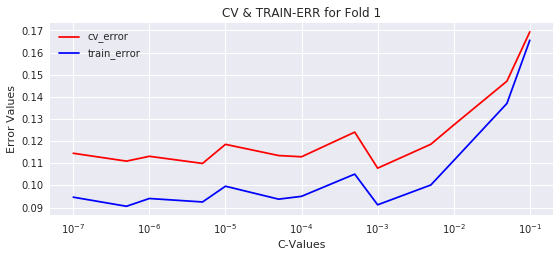

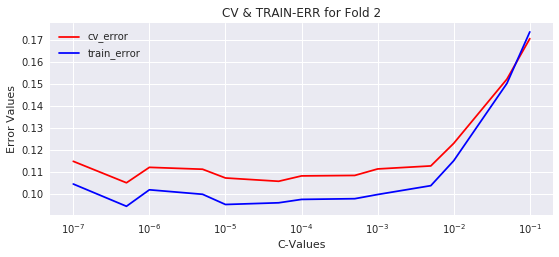

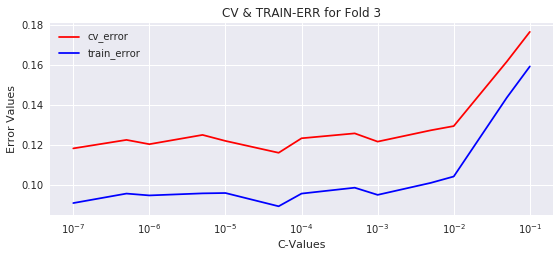

In [41]:
# error plot between cv error and train error 
error_comparision(cv_err, train_err)

#### Observation:
* As C value increases both train and cv error rate increases indicating that, for large alpha linear SVC starts to underfit.

In [42]:
# applying bow to test and train data 
bow_model = count_vect.fit(train_x['CleanedText'].values)
final_counts_train = bow_model.transform(train_x['CleanedText'].values)
final_counts_test = bow_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [45]:
# finding best fit alpha using grid search 
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

SGDClassifier(alpha=5e-05, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='hinge', max_iter=None,
       n_iter=None, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
0.9296196587251786


### [D.] Random Search 

In [46]:
# finding best fit alpha using random search 
random_search_cv(final_counts_train, train_y, final_counts_test, test_y)

SGDClassifier(alpha=9.929447160772466e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.1, fit_intercept=True,
       l1_ratio=0.15, learning_rate='invscaling', loss='hinge',
       max_iter=None, n_iter=None, n_jobs=-1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
0.9287566866591019


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for alpha = '5e-05' is '97.30285714285715'


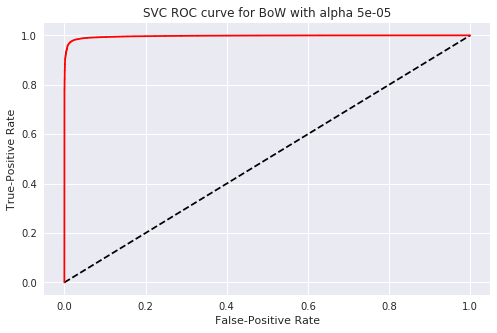

Area under the ROC curve is  0.9969883373040518

Confusion Matrix :
 [[ 8057   111]
 [ 1777 60055]]

Normalized Confusion Matrix :
 [[0.98641038 0.01358962]
 [0.02873916 0.97126084]]

Precision  : 81.93%, 99.82%
Recall     : 98.64%, 97.13%
F1-score   : [0.89512276 0.98452434]


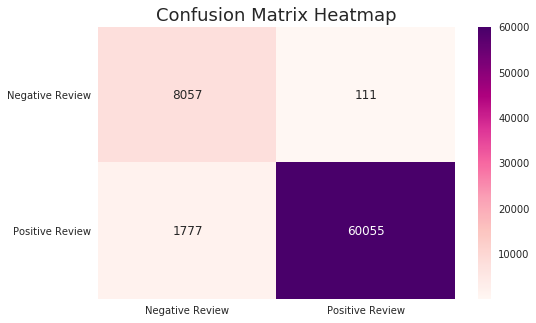

				ACCURACY METRIC FOR TEST-SET


Test accuracy for alpha = '5e-05' is '91.22333333333333'


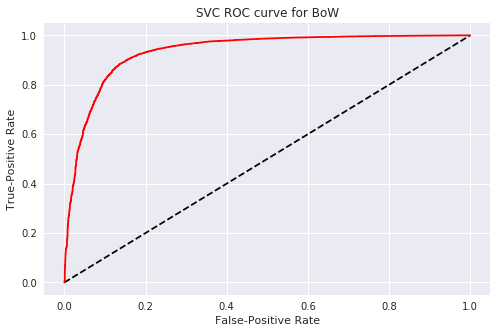

Area under the ROC curve is  0.9341257753218375

Confusion Matrix :
 [[ 3294   809]
 [ 1824 24073]]

Normalized Confusion Matrix :
 [[0.8028272  0.1971728 ]
 [0.07043287 0.92956713]]

Precision  : 64.36%, 96.75%
Recall     : 80.28%, 92.96%
F1-score   : [0.71445613 0.94814786]


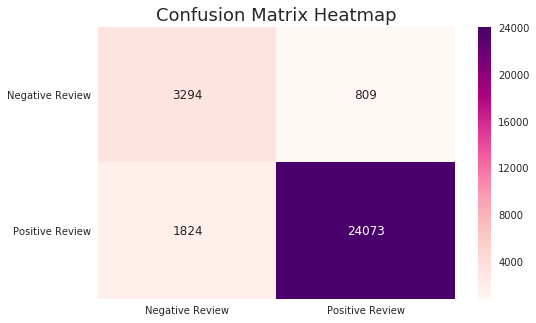

In [48]:
# accuracy measures for train and test data
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 0.00005, 'BoW')

### [F.] Top Features from Each Class

In [51]:
# printing top features(i.e words here) for each class
top_features(final_counts_train, train_y, count_vect, 10, 0.00005)

Top 10 "NEGATIVE" Features are:

disappoint
unfortun
terribl
worst
bland
aw
stale
not good
didnt
money

Top 10 "POSITIVE" Features are:

satisfact say
bazaar near
butter pie
ago food
town parma
vent duct
coincid anyway
healthi alert
school knew
imposs burn


## 7. TF-IDF

In [52]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 0)

### [A.] Linear Support Vector Classifier 

In [76]:
# applying linear svc
train_err, cv_err = svc_sgd(train_x, train_y, tf_idf_vect)

In [77]:
cv_err = np.reshape(cv_err,(3, 13))
train_err = np.reshape(train_err,(3, 13))

### [B.] Error Plot Over Different Values of Hyperparameter alpha (α)

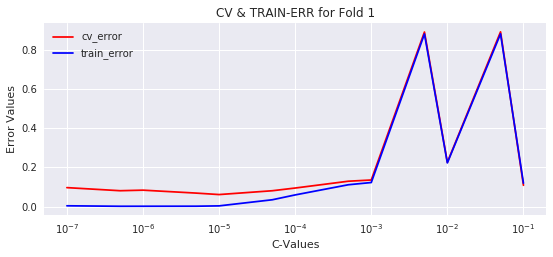

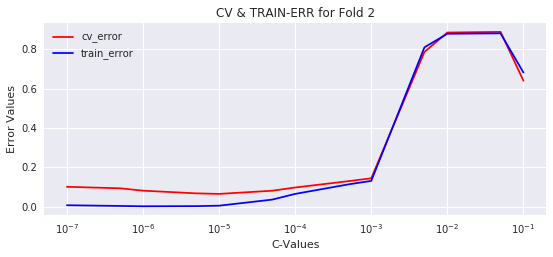

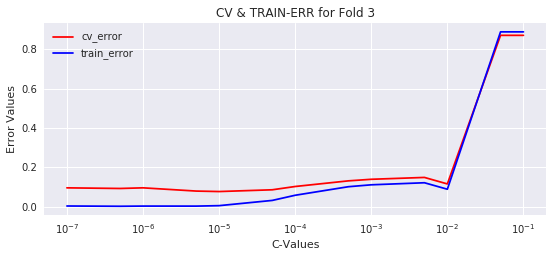

In [78]:
# error plot between cv error and test error 
error_comparision(cv_err, train_err)

#### Observation:
* As C value increases both train and cv error rate increases indicating that, for large alpha linear SVC starts to underfit.

In [79]:
# applying tfidf to test and train data
tfidf_model = tf_idf_vect.fit(train_x['CleanedText'].values)
final_counts_train = tfidf_model.transform(train_x['CleanedText'].values)
final_counts_test = tfidf_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [83]:
# finding best fit alpha using grid search 
grid_search_cv(final_counts_train, train_y, final_counts_test, test_y)

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.001, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9597869817884979


### [D.] Random Search 

In [84]:
# finding best fit alpha using random search 
random_search_cv(final_counts_train, train_y, final_counts_test, test_y)

SGDClassifier(alpha=7.682295874175265e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=None, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
0.9377369142672797


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for alpha = '1e-05' is '99.15'


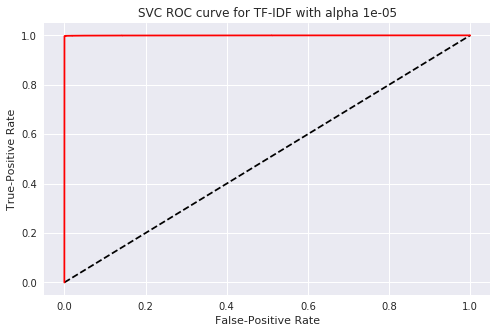

Area under the ROC curve is  0.999695391751546

Confusion Matrix :
 [[ 8167     1]
 [  594 61238]]

Normalized Confusion Matrix :
 [[9.99877571e-01 1.22428991e-04]
 [9.60667615e-03 9.90393324e-01]]

Precision  : 93.22%, 100.00%
Recall     : 99.99%, 99.04%
F1-score   : [0.96485321 0.99516539]


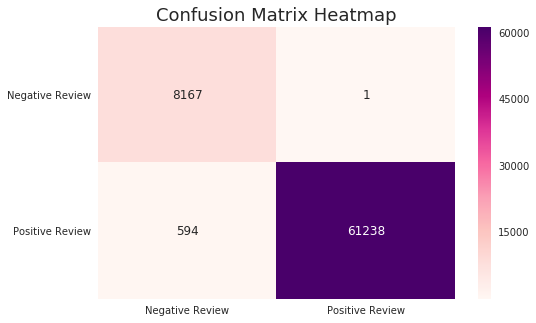

				ACCURACY METRIC FOR TEST-SET


Test accuracy for alpha = '1e-05' is '93.08666666666666'


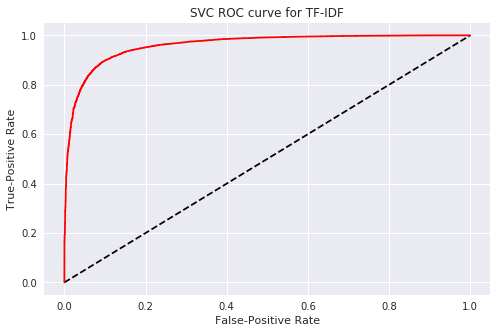

Area under the ROC curve is  0.9608381893771394

Confusion Matrix :
 [[ 3283   820]
 [ 1254 24643]]

Normalized Confusion Matrix :
 [[0.80014623 0.19985377]
 [0.0484226  0.9515774 ]]

Precision  : 72.36%, 96.78%
Recall     : 80.01%, 95.16%
F1-score   : [0.7599537  0.95961838]


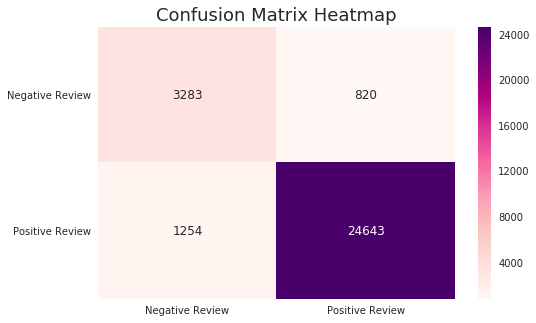

In [86]:
# accuracy measures for train and test
final_test_acc(final_counts_train, train_y, final_counts_test, test_y, 0.00001, 'TF-IDF')

### [F.] Top Features from Each Class

In [88]:
# printing top features(i.e words here) for each class
top_features(final_counts_train, train_y, tf_idf_vect, 10, 0.00001)

Top 10 "NEGATIVE" Features are:

disappoint
not worth
worst
not
bland
terribl
aw
unfortun
not good
not recommend

Top 10 "POSITIVE" Features are:

satisfact say
haul began
ago food
healthiest best
town parma
butter pie
vent duct
bazaar near
healthi alert
head bottl


## 8. Word2Vec

In [89]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [90]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [91]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [92]:
print(sorted_data['Text'].values[0])
print(list_of_sent[0])

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
['this', 'witty', 'little', 'book', 'makes', 'my', 'son', 'laugh', 'at', 'loud', 'i', 'recite', 'it', 'in', 'the', 'car', 'as', 'were', 'driving', 'along', 'and', 'he', 'always', 'can', 'sing', 'the', 'refrain', 'hes', 'learned', 'about', 'whales', 'india', 'drooping', 'i', 'love', 'all', 'the', 'new', 'words', 'this', 'book', 'introduces', 'and', 'the', 'silliness', 'of', 'it', 'all', 'this', 'is', 'a', 'classic', 'book', 'i', 'am', 'willing', 'to', 'bet', 'my', 'son', 'will', 'still', 'be', 'able', 'to', 'recite', 'from', 'memory', 'when', 'he', 'is', 'in', 'college']


## 9. Avg Word2Vec & TF-IDF Word2Vec

In [93]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [94]:
train_x, test_x, train_y, test_y = data_split(list_of_sent[:100000], score[:100000])

### [A.] Linear Support Vector Classifier 

In [122]:
# applying linear svc
train_err, cv_err = sgd_w2v(np.array(train_x), np.array(train_y))

In [123]:
cv_err = np.reshape(cv_err,(3, 13))
train_err = np.reshape(train_err,(3, 13))

### [B.] Error Plot Over Different Values of Hyperparameter alpha (α)

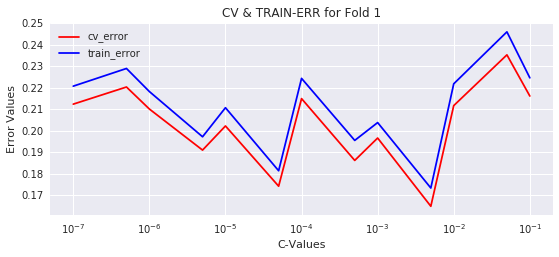

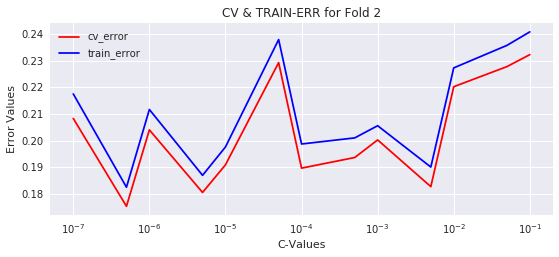

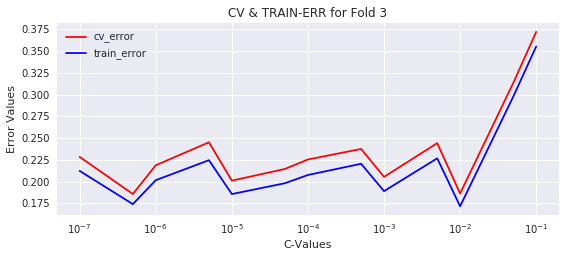

In [124]:
# error plot between cv error and test error 
error_comparision(cv_err, train_err)

#### Observation:
* For Avg-Word2Vec representation it seems like the error curve is not convex, so we are getting zig-zag error plot.

In [125]:
# applying w2v to train and test data
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=8)
train_vect = avg_w2v(train_x, w2v_model)
test_vect = avg_w2v(test_x, w2v_model)

In [126]:
train_vect = np.nan_to_num(train_vect)
test_vect = np.nan_to_num(test_vect)

### [C.] Grid Search 

In [127]:
# finding best fit alpha using grid search
grid_search_cv(train_vect, train_y, test_vect, test_y)

SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.001, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.886631620834817


### [D.] Random Search 

In [128]:
# finding best fit alpha using grid search
random_search_cv(train_vect, train_y, test_vect, test_y)

SGDClassifier(alpha=8.773757306170927e-05, average=False,
       class_weight='balanced', epsilon=0.1, eta0=0.001,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', max_iter=None, n_iter=None, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)
0.922903391775834


### [E.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for alpha = '0.001' is '81.63571428571429'


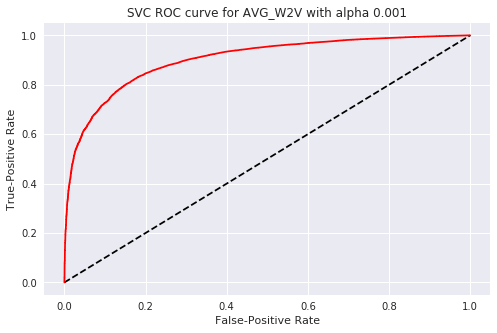

Area under the ROC curve is  0.9019276430009902

Confusion Matrix :
 [[ 6824  1344]
 [11511 50321]]

Normalized Confusion Matrix :
 [[0.83545544 0.16454456]
 [0.18616574 0.81383426]]

Precision  : 37.22%, 97.40%
Recall     : 83.55%, 81.38%
F1-score   : [0.51496057 0.88673709]


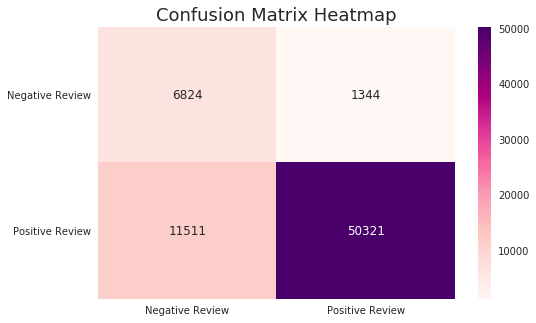

				ACCURACY METRIC FOR TEST-SET


Test accuracy for alpha = '0.001' is '81.45666666666666'


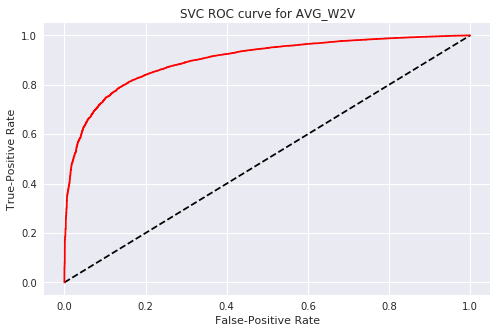

Area under the ROC curve is  0.9002661050863763

Confusion Matrix :
 [[ 3454   649]
 [ 4914 20983]]

Normalized Confusion Matrix :
 [[0.84182306 0.15817694]
 [0.18975171 0.81024829]]

Precision  : 41.28%, 97.00%
Recall     : 84.18%, 81.02%
F1-score   : [0.55392511 0.88295567]


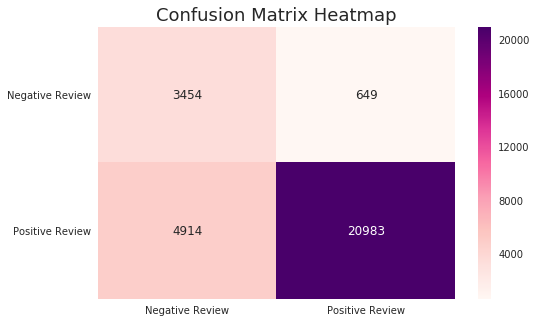

In [130]:
# accuracy matric for train and test data
final_test_acc(train_vect, train_y, test_vect, test_y, 0.001, 'AVG_W2V')

### 9.1 TF-IDF W2V

In [132]:
# Determining TF-IDF weighted Word2Vec
def tfidf_w2v(data, model, tfidf_dict):
    tfidf_feat = tf_idf_vect.get_feature_names() 
    tfidf_sent_vectors = []
    row = 0
    for sent in data: 
        sent_vec = np.zeros(100)
        weight_sum = 0 
        for word in sent: 
            try:
                vec = model.wv[word]
                tf_idf = tfidf_dict[row, tfidf_feat.index(word)]
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return np.matrix(tfidf_sent_vectors)

In [133]:
train_x, test_x, train_y, test_y, raw_x, raw_y = train_test_split(list_of_sent[:100000], score[:100000], sorted_data.CleanedText[:100000].values,
                                                                 test_size=0.3, shuffle=False)

### [A.] Linear Support Vector Classifier 

In [169]:
# applying linear svc
train_err, cv_err = sgd_tfidf_w2v(train_x[:100000], train_y[:100000], raw_x[:100000])

In [170]:
cv_err = np.reshape(cv_err,(3, 13))
train_err = np.reshape(train_err,(3, 13))

### [B.] Error Plot Over Different Values of Hyperparameter alpha (α)

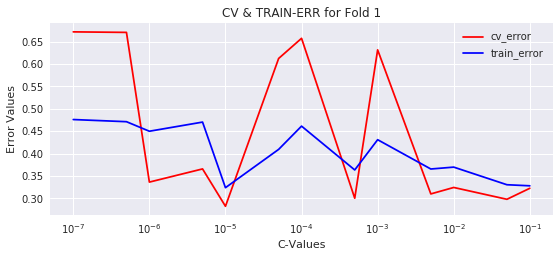

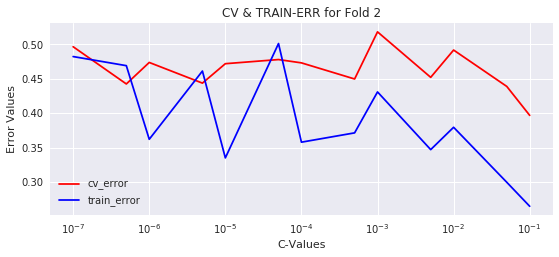

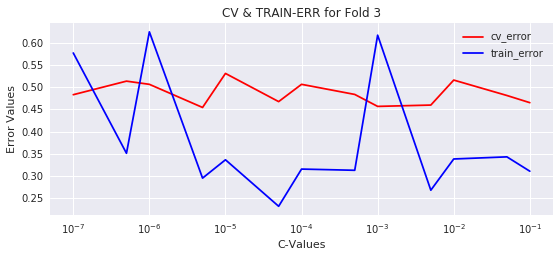

In [171]:
error_comparision(cv_err, train_err)

#### Observation:
* For TFIDF-Word2Vec representation it seems like the error curve is not convex, so we are getting up and down error plot and overfits as alpha increases.


In [172]:
# applying tf-idf weighted w2v to train and test set 
w2v_model = gensim.models.Word2Vec(train_x, min_count=5, size=100, workers=-1)
tfidf_dict = tf_idf_vect.fit_transform(raw_x)
train_vect = tfidf_w2v(list_of_sent[:70000], w2v_model, tfidf_dict)
test_vect = tfidf_w2v(list_of_sent[70000:100000], w2v_model, tfidf_dict)

In [173]:
train_vect = np.nan_to_num(train_vect)
test_vect = np.nan_to_num(test_vect)

### [C.] Grid Search

In [174]:
# finding best fit alpha using grid search
grid_search_cv(train_vect, train_y, test_vect, test_y)

SGDClassifier(alpha=5e-05, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.001, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=-1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9265971340143478


### [D.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for alpha = '1e-07' is '88.32714285714286'


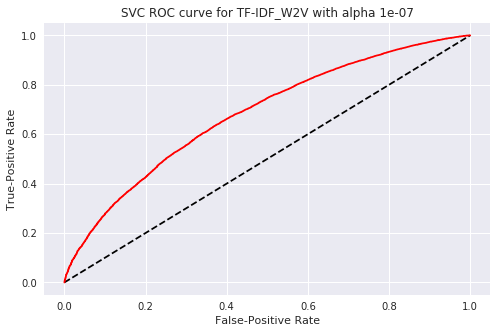

Area under the ROC curve is  0.681299195933463

Confusion Matrix :
 [[   84  8084]
 [   87 61745]]

Normalized Confusion Matrix :
 [[0.01028404 0.98971596]
 [0.00140704 0.99859296]]

Precision  : 49.12%, 88.42%
Recall     : 1.03%, 99.86%
F1-score   : [0.0201463 0.9379391]


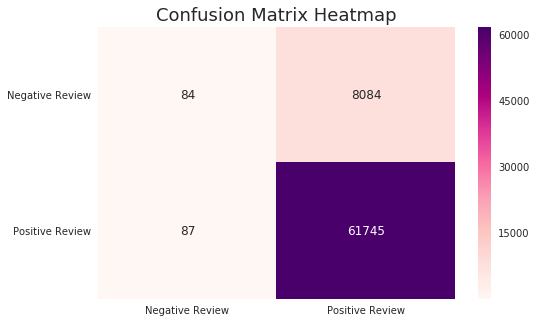

				ACCURACY METRIC FOR TEST-SET


Test accuracy for alpha = '1e-07' is '81.77333333333333'


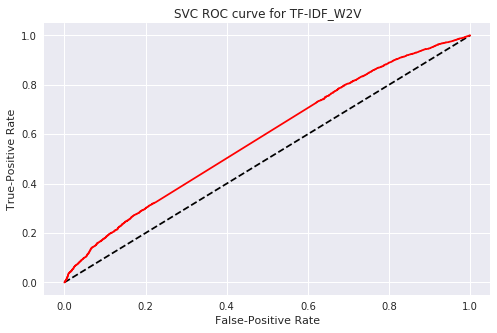

Area under the ROC curve is  0.5856991246684133

Confusion Matrix :
 [[  594  3509]
 [ 1959 23938]]

Normalized Confusion Matrix :
 [[0.14477212 0.85522788]
 [0.07564583 0.92435417]]

Precision  : 23.27%, 87.22%
Recall     : 14.48%, 92.44%
F1-score   : [0.17848558 0.8974955 ]


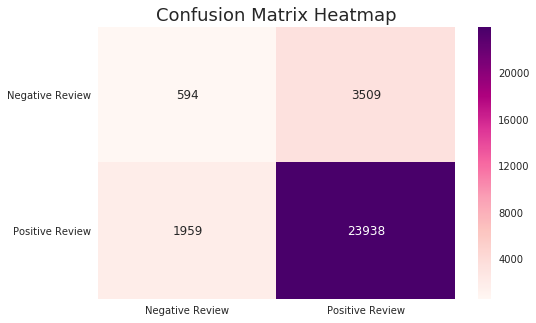

In [194]:
final_test_acc(train_vect, train_y, test_vect, test_y, 0.0000001, 'TF-IDF_W2V')

## 10. TF-IDF with RBF kernel 

In [197]:
train_x, test_x, train_y, test_y = data_split(sorted_data[:100000], score[:100000])

In [196]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 0)

### [A.] Support Vector Classifier with RBF kernel  

In [198]:
# applying svc with rbf kernel
train_err, cv_err = svc_rbf(train_x, train_y, tf_idf_vect)

In [201]:
cv_err = np.reshape(cv_err,(3, 15))
train_err = np.reshape(train_err,(3, 15))

### [B.] Error Plot Over Different Values of Hyperparameter C

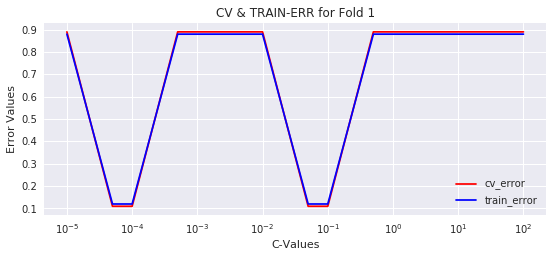

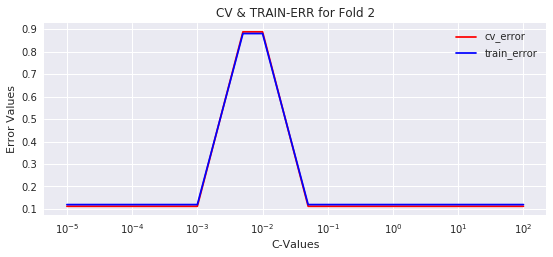

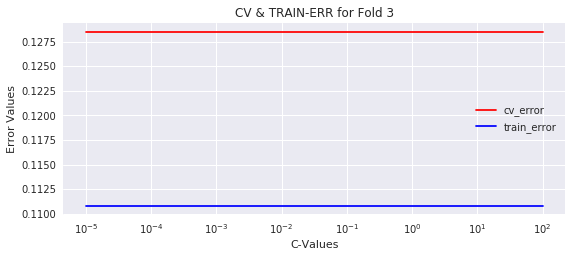

In [202]:
error_comparision_svc(cv_err, train_err)

In [203]:
# applying tfidf to test and train data
tfidf_model = tf_idf_vect.fit(train_x['CleanedText'].values)
final_counts_train = tfidf_model.transform(train_x['CleanedText'].values)
final_counts_test = tfidf_model.transform(test_x['CleanedText'].values)

### [C.] Grid Search 

In [208]:
# finding best fit alpha using grid search 
grid_search_svc(final_counts_train, train_y, final_counts_test, test_y)

SVC(C=5e-05, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9265971340143478


### [D.] Accuracy Matrics 

				ACCURACY METRIC FOR TRAIN-SET


Train accuracy for C = '5e-05' is '88.33142857142857'


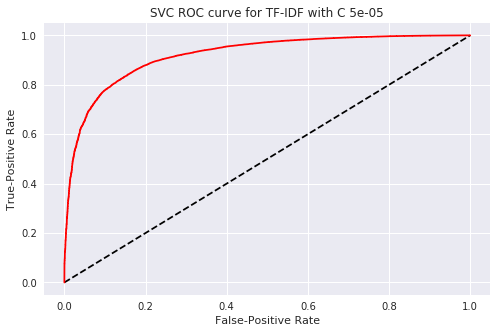

Area under the ROC curve is  0.9202526703348584

Confusion Matrix :
 [[    0  8168]
 [    0 61832]]

Normalized Confusion Matrix :
 [[0. 1.]
 [0. 1.]]

Precision  : 0.00%, 88.33%
Recall     : 0.00%, 100.00%
F1-score   : [0.         0.93804236]


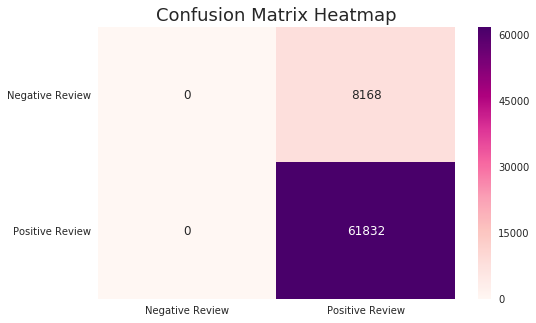

				ACCURACY METRIC FOR TEST-SET


Test accuracy for C = '5e-05' is '86.32333333333332'


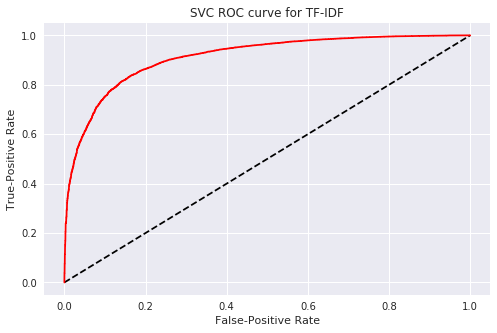

Area under the ROC curve is  0.9119999991341616

Confusion Matrix :
 [[    0  4103]
 [    0 25897]]

Normalized Confusion Matrix :
 [[0. 1.]
 [0. 1.]]

Precision  : 0.00%, 86.32%
Recall     : 0.00%, 100.00%
F1-score   : [0.         0.92659713]


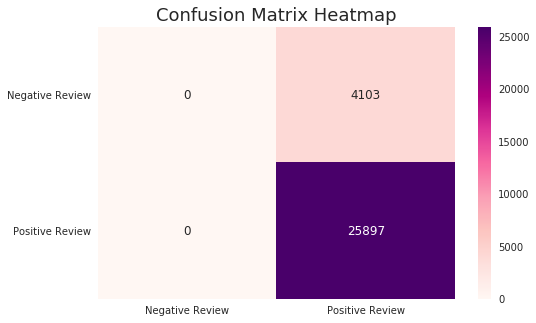

In [212]:
# accuracy measures for train and test
svc_test_acc(final_counts_train, train_y, final_counts_test, test_y, 0.00005, 'TF-IDF')

## 11. Summary

### Approach:
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;From all Amazon fine food reviews data-points i have taken only the reviews that have score 1, 2, 4 or 5. Then I applied some pre-processing methods to make data best fit to apply naive bayes model. After that I have declared some useful functions to modularize the whole process. For our end goal i.e to classify a review whether it is positive or not by using support vector classifier, we need to convert the textual data to numerial one. To do so i have used these four(given below) vectorization methods.<br>
</p>
<br>
1. Bag of Words(BoW)<br>
2. TF-IDF<br>
3. Avg Word2Vec<br>
4. TF-IDF W2V
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Before applying any model to our data we need to split the data into train and test set. Here I have taken 70% of the data(100000 datapoints) as train-set and rest 30% as test-data. The important part here is "I have sorted the data in ascending order of time stamp of the reviews" and then splitted the whole data without shuffling it. The only problem with this data set is that it is a imbalanced dataset i.e there is a mismatch between number of instances of each class. Here i'm having 87729 positive data-points and 12271 negative data-points. It means the given dataset is nearly 87.7% positive & 12.3% negative. 
</p>

<h3> Results:</h3>
<p align="center">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Linear SVC using SGDClassifier we have got alpha which is a hyper-parameter which handles the trade-off between overfitting and underfitting. To find best fit alpha i have used 3-Fold cross validation for each vectorization method and the performance of the model is compared by various accuracy matrics(ROC-AUC curve, precision, recall, F1-Score etc.) for each vectorization.
</p>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>1. BoW</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For BoW representation, we got best-fit alpha = 0.00005 from 3-Fold cross validation and grid search. And the accuracy metric for train and test data, taking alpha = 0.00005, is given below:-
 <table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.00005</td>
    <td>97.3%</td>
    <td>81.93%, 99.82%</td>
    <td>98.64%, 97.13%</td>
    <td>0.89 0.98</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.00005</td>
    <td>91.2%</td>
    <td>64.36%, 96.75%</td>
    <td>80.28%, 92.96%</td>
    <td>0.71 0.95</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 97.3% accuracy for train-data and 91.2% for test-data. But from F1-Score it is clear that our model is not that good in predicting negative class compared to the positive prediction. This problem occurs due the imbalanced data, still 0.71 F1-Score for negative prediction is pretty good as total negative data-points are only 12% of total data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>2. TF-IDF</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For TF-IDF representation, we got best-fit alpha = 0.00001 from 3-Fold cross validation. And the accuracy metric for train and test data, taking alpha = 0.00001, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.00001</td>
    <td>99.15%</td>
    <td>93.22%, 100.00%</td>
    <td>99.99%, 99.04%</td>
    <td>0.96 0.99</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.00001</td>
    <td>93%</td>
    <td>72.36%, 96.78%</td>
    <td>80.01%, 95.16%</td>
    <td>0.76 0.96</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 99.15% accuracy with high F1-Scores for train-data and 93% for test-data. But for test-data, negative class F1-Score is 0.76 which is too low compared to positive class F1-Score 0.96. Still the TF-IDF representation helped the model to perform better than BoW.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>3. Avg Word2Vec</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit alpha = 0.001 from 3-Fold cross validation. And the accuracy metric for train and test data, taking alpha = 0.001, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.001</td>
    <td>81.63%</td>
    <td>37.22%, 97.40%</td>
    <td>83.55%, 81.38%</td>
    <td>0.51 0.88</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.001</td>
    <td>81.45%</td>
    <td>41.28%, 97.00%</td>
    <td>84.18%, 81.02%</td>
    <td>0.55 0.88</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 81.63% accuracy with low F1-Scores for train-data and 81.45% for test-data. But for test-data, negative class F1-Score is poor i.e 0.55 which is too low compared to positive class F1-Score 0.88. So Avg Word2Vec didn't help the model to properly classify the given data.
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>4. TF-IDF W2V</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;For Avg Word2Vec representation, we got best-fit alpha = 0.0000001 from 3-Fold cross validation. And the accuracy metric for train and test data, taking alpha = 0.0000001, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>Alpha</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.0000001</td>
    <td>88.32%</td>
    <td>49.12%, 88.42%</td>
    <td>1.03%, 99.86%</td>
    <td>0.02 0.94</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.0000001</td>
    <td>81.77%</td>
    <td>23.27%, 87.22%</td>
    <td>14.48%, 92.44%</td>
    <td>0.18 0.90</td>
  </tr>
</table>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The model got 88.32% accuracy with worst negative F1-Score for train-data and 81.77% for test-data. But for test-data, negative class F1-Score is poor i.e 0.18 which is worse.<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<h4>SVC with RBF Kernel</h4><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We have only implemented linear svc using sklear.SGDClassifier with hinge loss here and found out that the TF-IDF representation worked well among other vectorization. So I applied sklearn.svc.SVC with RBF kernel to TF-IDF representation to check whether it performs better or not.After applying SVC with RBF kernel to the TF-IDF I got best-fit C to be 0.00005 from 3-Fold cross validation. And the accuracy metric for train and test data, taking C = 0.00005, is given below:-
<table>
  <tr>
    <th>Data</th>
    <th>C</th>
    <th>Accuracy</th>
    <th>Precision</th>
    <th>Recall</th>
    <th>F1-Score</th>
  </tr>
  <tr>
    <td>Train</td>
    <td>0.00005</td>
    <td>88.33%</td>
    <td>0.00%, 88.33%</td>
    <td>0.00%, 100.00%</td>
    <td>0. 0.94</td>
  </tr>
  <tr>
    <td>Test</td>
    <td>0.00005</td>
    <td>86.32%</td>
    <td>0.00%, 86.32%</td>
    <td>0.00%, 100.00%</td>
    <td>0. 0.92</td>
  </tr>
</table>
<br> 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;SVC with RBF kernel performed very bad as it assigned all the data points positive i.e assigned with majority class. So in short It performed worse than the random classification.
<h3> Conclusion:</h3><br>
1. The model performed well for both BoW vectorization and TF-IDF vectorization in classifing the review.<br> 
2. The linear SVC model performed well, even the dataset is 88%-12% imbalanced, with 80% true negative rate and nearly 95% true positive rate.<br>
3. As the dimensionality of the feature vector is very large, so the possibility to find a linear separating plane is very high. That's why linear SVC worked far better than the SVC with RBF kernel.